## Setup

In [1]:
import cv2
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import os.path as osp
import os
import xml.etree.ElementTree as ET
import imutils
import cyvlfeat as vlfeat
from sklearn.svm import LinearSVC, SVC
from skimage import filters
from skimage.feature import corner_peaks
import pickle
from random import shuffle
from scipy.spatial.distance import cdist
from xgboost import XGBClassifier

In [2]:
from voc_eval import *

def evaluate_mAP(path):
    detpath = path
    annopath = 'datasets/Annotations/{}.xml'
    imagesetfile = 'datasets/ImageSets/val.txt'
    cachedir = 'cache_anno'

    classes = ['wenda']
    meanAP = 0
    for idx, classname in enumerate(classes) :
        rec, prec, ap = voc_eval(detpath, annopath, imagesetfile, classname,
                                                cachedir, ovthresh=0.5, use_07_metric=False)
        meanAP += ap
        print('{}: {}'.format(classname, ap))

    print('meanAP: {}'.format(meanAP/len(classes)))

## Cascade Classifier

In [3]:
wenda_cascade = cv2.CascadeClassifier('cascade_wenda/classifier/cascade.xml')

def cascade_detection(img_number):
    img = imread('datasets/JPEGImages/' + img_number + '.jpg')
    img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    wenda_candidates, reject_levels, level_weights = wenda_cascade.detectMultiScale3(img_grey, 1.03, 3, outputRejectLevels=True)
    for (x,y,w,h) in wenda_candidates:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),10)
        roi_gray = img_grey[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
    
    plt.imshow(img, interpolation='nearest')
    plt.show()
    # plt.imsave('dump.jpg', img)
    
    return wenda_candidates, level_weights

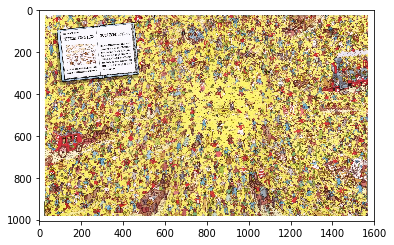

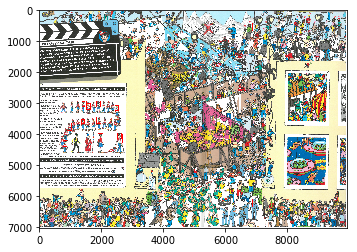

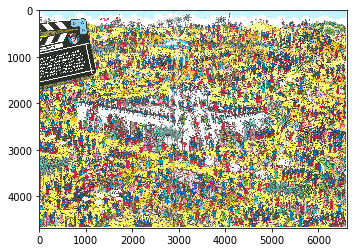

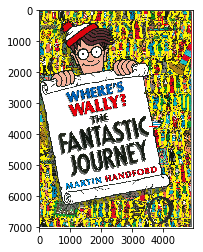

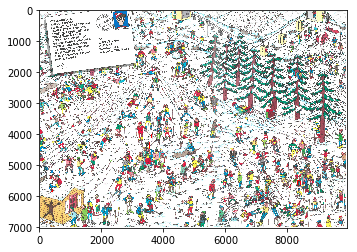

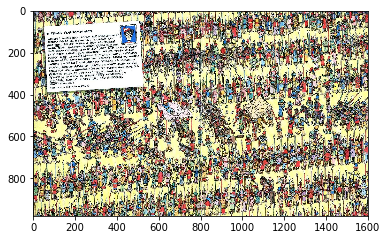

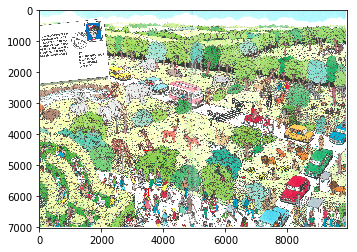

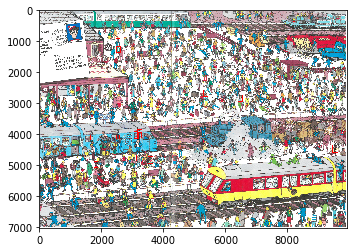

['003', '018', '036', '043', '038', '056', '067', '074']


In [4]:
image_ids = []
wenda_candidates_all = []
level_weights_all = []

with open('datasets/ImageSets/val.txt') as file:
    for img_id in file.readlines():
        img_id = img_id.rstrip()
        image_ids.append(img_id)
        wenda_candidates, level_weights = cascade_detection(img_id)
        wenda_candidates_all.append(wenda_candidates)
        level_weights_all.append(level_weights)
        
print(image_ids)

In [5]:
with open('my_wenda_cascade.txt', 'w+') as output:
    for i in range(len(image_ids)):
        img_id = image_ids[i]
        print(img_id)
        wenda_candidates = wenda_candidates_all[i]
        print(wenda_candidates)
        level_weights = level_weights_all[i]
        print(level_weights)
        
        for j in range(len(wenda_candidates)):
            x,y,w,h = wenda_candidates[j]
            conf = level_weights[j][0]
            result = str(img_id) + ' ' + str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(x + w) + ' ' + str(y + h)
            
            if not j == len(wenda_candidates) - 1:
                result += '\n'
            
            print(result)
            output.write(result)

003
()
()
018
[[6705  416  174  261]
 [2446 3068  110  165]
 [1381 2945  105  157]
 [1379 3527   84  126]
 [1526 3007  128  192]
 [1852 2937  130  194]
 [1357 2937  168  253]
 [1855 3449  137  206]
 [1367 3522  119  178]
 [2526 3956  128  191]
 [ 892 3642  154  231]
 [2489 3991  198  296]
 [1908 3972  145  217]
 [ 780 4198  132  199]
 [2265 6091  118  176]
 [6872 6090  160  241]]
[[-0.88625154]
 [ 1.48223481]
 [ 0.70224229]
 [-1.65890417]
 [ 0.70224229]
 [-0.79150832]
 [ 0.70958218]
 [-0.83324376]
 [-0.91281086]
 [-0.02359003]
 [-1.61208385]
 [-0.11324838]
 [ 0.70224229]
 [ 0.75640249]
 [-0.065676  ]
 [-0.83682567]]
018 -0.886251538992 6705 416 6879 677

018 1.48223480582 2446 3068 2556 3233

018 0.702242285013 1381 2945 1486 3102

018 -1.65890416503 1379 3527 1463 3653

018 0.702242285013 1526 3007 1654 3199

018 -0.791508316994 1852 2937 1982 3131

018 0.709582179785 1357 2937 1525 3190

018 -0.833243757486 1855 3449 1992 3655

018 -0.912810862064 1367 3522 1486 3700

018 -0.02359002

In [7]:
evaluate_mAP('my_wenda_cascade.txt')

wenda: 0.11011904761904762
meanAP: 0.11011904761904762


## Cascade Classifier + Bags-of-SIFTs + XGBoost Classifier

In [8]:
def bags_of_sifts(image_paths=[], vocab_filename='', img=None):

    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

    vocab_size = vocab.shape[0]
    feats = []
    
    if len(image_paths) == 0:
        image_paths = ['']
    
    for path in image_paths:
        image = np.asarray(plt.imread(path)) if path != '' else img
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=10)
        samples = descriptors
        D = cdist(samples, vocab)
        closest_words = np.argmin(D, axis=1)
        histogram, bin_edges = np.histogram(closest_words, bins=np.arange(0, vocab_size+1))    
        histogram = histogram / np.linalg.norm(histogram)
        feats.append(histogram)
        
    N = len(image_paths)
    d = vocab_size
    feats = np.asarray(feats)
    feats = feats.reshape((N,d))
    return feats


def build_vocabulary(image_paths, vocab_size):
    dim = 128     
    vocab = np.zeros((vocab_size,dim))
    sift_features = []

    for path in image_paths:
        image = np.asarray(plt.imread(path))
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        (frames, descriptors) = vlfeat.sift.dsift(img_gray, fast=True, step=5)

        samples = np.random.permutation(descriptors)[:20]

        for descriptor in samples:
            sift_features.append(descriptor)

    sift_features = np.asarray(sift_features).astype('float64').reshape((-1,128))
    vocab = vlfeat.kmeans.kmeans(sift_features, vocab_size)

    return vocab


def test_accuracy(test_labels, predicted_labels):
    num_correct = 0
    for i,label in enumerate(test_labels):
        if (predicted_labels[i] == label):
            num_correct += 1
    return num_correct/len(test_labels)

In [9]:
waldo_paths = []
wenda_paths = []
wizard_paths = []
negative_paths = []
all_paths = []

test_image_paths = []
with open('datasets/ImageSets/val.txt') as file:
    for img_id in file.readlines():
        img_id = img_id.rstrip()
        test_image_paths.append('datasets/JPEGImages/{}.jpg'.format(img_id))

file.close()


template_dirs = ["templates/waldo","templates/wenda","templates/wizard"]

for i in range(len(template_dirs)):
    for img_id in os.listdir(template_dirs[i]):
        path_to_dir = os.path.join(template_dirs[i], '{}'.format(img_id)).rstrip()
        if not os.path.isdir(path_to_dir):
            continue
        list_of_files = os.listdir(path_to_dir)
        for file_name in list_of_files:
            all_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==0:
                waldo_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==1:
                wenda_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())
            if i==2:
                wizard_paths.append(os.path.join(path_to_dir, '{}'.format(file_name)).rstrip())

negative_dir = "negatives_same_scale"
for img_file in os.listdir(negative_dir):
    negative_paths.append(os.path.join(negative_dir, '{}'.format(img_file)).rstrip())
    
waldo_all_paths = []
waldo_all_paths.extend(waldo_paths)
waldo_all_paths.extend(negative_paths)
print(len(waldo_all_paths))

308


In [10]:
vocab_filename = 'vocab_waldo.pkl'
vocab_size = 200
vocab = build_vocabulary(waldo_all_paths,vocab_size)
    
with open(vocab_filename, 'wb') as f:
    pickle.dump(vocab, f)

In [11]:
template_percentage = 0.8

waldo_feats = bags_of_sifts(waldo_paths[:int(len(waldo_paths)*template_percentage)],vocab_filename)
# wenda_feats = bags_of_sifts(wenda_paths[:int(len(wenda_paths)*template_percentage)],vocab_filename)
# wizard_feats = bags_of_sifts(wizard_paths[:int(len(wizard_paths)*template_percentage)],vocab_filename)
negative_feats = bags_of_sifts(negative_paths[:int(len(negative_paths)*template_percentage)], vocab_filename)

training_feats = []
training_feats.extend(waldo_feats)
# training_feats.extend(wenda_feats)
# training_feats.extend(wizard_feats)
training_feats.extend(negative_feats)

# test_image_feats 
waldo_test_feats = bags_of_sifts(waldo_paths[int(len(waldo_paths)*template_percentage):len(waldo_paths)],vocab_filename)
# wenda_test_feats = bags_of_sifts(wenda_paths[int(len(wenda_paths)*template_percentage):len(wenda_paths)],vocab_filename)
# wizard_test_feats = bags_of_sifts(wizard_paths[int(len(wizard_paths)*template_percentage):len(wizard_paths)],vocab_filename)
negative_test_feats = bags_of_sifts(negative_paths[int(len(negative_paths)*template_percentage):len(negative_paths)],vocab_filename)

test_feats = []
test_feats.extend(waldo_test_feats)
# test_feats.extend(wenda_test_feats)
# test_feats.extend(wizard_test_feats)
test_feats.extend(negative_test_feats)

#set training labels
train_labels = []
train_labels.extend([0]*len(waldo_feats))
# train_labels.extend([1]*len(wenda_feats))
# train_labels.extend([2]*len(wizard_feats))
train_labels.extend([1]*len(negative_feats))

ground_truth_test_labels = []
ground_truth_test_labels.extend([0]*len(waldo_test_feats))
# ground_truth_test_labels.extend([1]*len(wenda_test_feats))
# ground_truth_test_labels.extend([2]*len(wizard_test_feats))
ground_truth_test_labels.extend([1]*len(negative_test_feats))

In [12]:
model = XGBClassifier(learning_rate=0.01, 
                      n_estimators=2000, 
                      max_depth=3, 
                      subsample=0.8, 
                      colsample_bytree=1,
                      n_jobs=20)
model.fit(np.asarray(training_feats), np.asarray(train_labels))
predicted = model.predict(np.asarray(test_feats))
# print(predicted)
print(test_accuracy(ground_truth_test_labels, predicted))

0.7419354838709677


In [13]:
def xgb_classifier(candidates, img_number):
    valid_candidates = []
    valid_confidence = []
    img = imread('datasets/JPEGImages/' + img_number + '.jpg')
    for i in range(len(candidates)):
        (x,y,w,h) = candidates[i]
        patch = img[y:y+h, x:x+w]
        feats = bags_of_sifts(vocab_filename=vocab_filename, img=patch)
        prediction = model.predict_proba(np.asarray(feats))
        label = np.argmax(prediction, axis=1)
        
        if label == 0:
            valid_candidates.append(i)
            valid_confidence.extend(prediction[0][label])
            
    return valid_candidates, valid_confidence

In [14]:
with open('my_waldo_xgb.txt', 'w+') as output:
    for i in range(len(image_ids)):
        img_id = image_ids[i]
        print(img_id)
        waldo_candidates = waldo_candidates_all[i]
        waldos, confidence = xgb_classifier(waldo_candidates, img_id)
        print(waldos)
        print(confidence)
        
        for j in range(len(waldos)):
            (x,y,w,h) = waldo_candidates[waldos[j]]
            result = str(img_id) + ' ' + str(confidence[j]) + ' ' + str(x) + ' ' + str(y) + ' ' + str(x + w) + ' ' + str(y + h)
            
            if not j == len(waldo_candidates) - 1:
                result += '\n'
            
            print(result)
            output.write(result)

003
[]
[]
018
[7, 14, 22]
[0.56275284, 0.85820448, 0.54454046]
018 0.562753 4646 2942 4765 3120

018 0.858204 1182 2924 1343 3165

018 0.54454 1910 3962 2060 4187

036
[7]
[0.96119529]
036 0.961195 107 3150 206 3299

043
[1, 2, 3, 6]
[0.52768445, 0.54056704, 0.89293027, 0.88546884]
043 0.527684 2662 5 2908 374

043 0.540567 134 10 364 356

043 0.89293 4252 1131 4458 1439

043 0.885469 3762 2151 3985 2486

038
[3, 5, 6]
[0.79660314, 0.55492491, 0.77478522]
038 0.796603 2444 41 2807 585

038 0.554925 5536 2534 5656 2714

038 0.774785 3412 4246 3565 4474

056
[2]
[0.72739959]
056 0.7274 1078 568 1135 653

067
[0, 9]
[0.59398043, 0.73401558]
067 0.59398 1560 422 1939 990

067 0.734016 3381 5715 3483 5869

074
[5, 8]
[0.61284673, 0.63657004]
074 0.612847 6480 402 6675 694

074 0.63657 7024 2367 7109 2494



In [15]:
evaluate_mAP('my_waldo_xgb.txt')

waldo: 0.029370629370629373
meanAP: 0.029370629370629373


## Cascade Classifier + Template Matching

In [16]:
templates = ['templates/waldo/019/1.jpg', 'templates/waldo/026/1.jpg']

def template_matching(img):
    res = []
    for path in templates:
        template = imread(path)
        template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        template = cv2.Canny(template, 50, 200)
        (tH, tW) = template.shape[:2]
        
        found = None
        img = imutils.resize(img, width=int(img.shape[1] * 2), height=int(img.shape[0] * 2))
 
        # loop over the scales of the image
        for scale in np.linspace(0.2, 1.0, 20)[::-1]:
            # resize the image according to the scale, and keep track
            # of the ratio of the resizing
            resized = imutils.resize(img, width=int(img.shape[1] * scale), height=int(img.shape[0] * scale))
            r = img.shape[1] / float(resized.shape[1])
 
            # if the resized image is smaller than the template, then break
            # from the loop
            if resized.shape[0] < tH or resized.shape[1] < tW:
                break
                
            # detect edges in the resized, grayscale image and apply template
            # matching to find the template in the image
            edged = cv2.Canny(resized, 50, 200)
            result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF_NORMED)
            (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

            # if we have found a new maximum correlation value, then update
            # the bookkeeping variable
            if found is None or maxVal > found[0]:
                found = (maxVal, maxLoc, r)

        # unpack the bookkeeping variable and compute the (x, y) coordinates
        # of the bounding box based on the resized ratio
        (maxVal, maxLoc, r) = found
        (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
        (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
        
        _res = str(maxVal) + ' ' + str(startX) + ' ' + str(startY) + ' ' + str(endX) + ' ' + str(endY)
        res.append(_res)
    return res

In [17]:
with open('my_waldo_tm.txt', 'w+') as output:
    for i in range(len(image_ids)):
        img_id = image_ids[i]
        print(img_id)
        waldo_candidates = waldo_candidates_all[i]
        print(waldo_candidates)
        
        for j in range(len(waldo_candidates)):
            (x,y,w,h) = waldo_candidates[j]
            img = imread('datasets/JPEGImages/' + img_id + '.jpg')
            img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            patch = img_grey[y:y+h, x:x+w]
            results = template_matching(patch)
            
            for k in range(len(results)):
                result = results[k]
                result = img_id + ' ' + result
                
                if j != len(waldo_candidates) - 1 or k != len(results) - 1:
                    result += '\n'
                
                print(result)
                output.write(result)

003
[[ 501   32   51   77]
 [1520  324   60   89]
 [   9  503  215  322]]
003 0.05989651381969452 9 12 95 122

003 0.08337219804525375 91 60 161 227

003 0.03950822353363037 34 45 120 155

003 0.10760314017534256 172 66 239 225

003 0.0902373269200325 243 224 333 340

003 0.1045069620013237 380 514 505 811

018
[[1950  587  342  513]
 [9217 2170   86  128]
 [1843 2927  177  265]
 [ 986 3016  178  266]
 [2411 3150  261  392]
 [1389 3952  488  732]
 [1357 2922  154  231]
 [4646 2942  119  178]
 [2192 2907  111  166]
 [ 730 2912  136  204]
 [2314 2944  134  201]
 [1680 2938  155  232]
 [1512 2946  161  242]
 [2029 2922  140  211]
 [1182 2924  161  241]
 [2054 3415  153  229]
 [1180 3449  155  233]
 [1354 3463  157  235]
 [1018 3926  442  663]
 [2437 4046  370  555]
 [1839 4013  353  529]
 [2517 3945  145  218]
 [1910 3962  150  225]
 [1164 3963  116  175]
 [1494 3448  193  290]
 [1859 3461  197  296]
 [3564 5116  133  200]
 [8446 6096  104  156]
 [ 429 5908  225  337]]
018 0.1583350747823

074 0.08074131608009338 12 44 103 160

074 0.10347132384777069 132 45 199 204

074 0.08655378222465515 2 72 88 182

074 0.12265203893184662 252 246 319 405

074 0.08074071258306503 65 37 226 243

074 0.11777494847774506 381 101 454 275

074 0.11010117083787918 93 4 267 226

074 0.1339864283800125 390 385 475 587

074 0.11852297186851501 128 201 244 348

074 0.13352477550506592 708 606 803 832

074 0.12416929006576538 124 327 218 447

074 0.12669558823108673 665 523 773 780

074 0.14196649193763733 146 988 240 1109

074 0.13514533638954163 719 1175 795 1357

074 0.07158203423023224 1 44 91 159

074 0.11943614482879639 112 150 179 309

074 0.09508944302797318 3 5 89 115

074 0.10647951811552048 255 168 340 370

074 0.09097554534673691 97 3 206 143

074 0.10012619197368622 410 12 483 185

074 0.1007615178823471 32 205 141 344

074 0.12648363411426544 329 469 424 694

074 0.09768623858690262 30 157 116 267

074 0.12051507085561752 468 109 535 268

074 0.07249520719051361 14 118 104 233

07

In [18]:
evaluate_mAP('my_waldo_tm.txt')

waldo: 0.0
meanAP: 0.0
